In [41]:
import matplotlib.pyplot as plt
import quantecon as qe
import numpy as np
import networkx as nx
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
ψ_0 = (0.3,0.7)
cdf = np.cumsum(ψ_0)
qe.random.draw(cdf,5)

array([1, 1, 0, 1, 0])

In [ ]:
# markov chain function
def mc_path(P, ψ_0=None, ts_length=1000):
    P = np.asarray(P) # ensure matrix P is a numpy array
    X = np.empty(ts_length,dtype=int) # this will be our chain

    # makes row (axis 1) into a cdf
    P_dist = np.cumsum(P,axis=1)

    # draw initial state, return zero if no arg is given
    if ψ_0 is not None:
        X_0 = qe.random.draw(np.cumsum(ψ_0)) # draw after converting to cdf
    else:
        X_0 = 0

    # the actual sim
    X[0] = X_0
    for t in range(ts_length-1):
        # update rule, but P(X_t, .) is basically row t of P
        X[t+1] = qe.random.draw(P_dist[X[t],:])

    return X

In [ ]:
P = [[0.4,0.6],
     [0.2,0.8]]

X = mc_path(P, ψ_0 = None, ts_length=10**6)
np.mean(X == 1) # checking ergodocity

np.float64(0.750386)

In [11]:
# using qe's function
mc = qe.MarkovChain(P, state_values=('unemployed', 'employed'))
mc.simulate(ts_length=4, init='employed')  # Start at employed initial state

array(['employed', 'employed', 'employed', 'employed'], dtype='<U10')

# Exercise 34.1
Imam and Temple, 2023, used a three state transition matrix to describe the transition of three states of a regime: growth, stagnation and collapse.
$$P := \begin{bmatrix}
0.68 & 0.12 & 0.20 \\
0.50 & 0.24 & 0.26 \\
0.36 & 0.18 & 0.46
\end{bmatrix}$$
where rows, from top to down, correspond to growth, stagnation and collapse.

In this exercise, 
1. visualize the transition matrix and show this process is asymptotically stationary.
2. calculate the stationary distribution using simulations
3. visualize the dynamics of $(\psi_{0}P^{t})(i)$ where $t \in 0,\dots,25$ and compare the convergent path with the previous transition matrix.

### Soln 1:
Visualized it correctly in my book
Since the matrix $P$ is everywhere positive, there must be a unique stationary distribution $\psi^{*}$ s.t. $\psi_{0}P^{t} \to \psi^{*}$ as $t \to \infty$. Hence, the process is asymptotically stationary.

In [14]:
# soln 2:
P = np.array([[0.68, 0.12, 0.20],
     [0.50, 0.24, 0.26],
     [0.36, 0.18, 0.46]])

P_power = np.linalg.matrix_power(P,100)
P_power

# clearly, all the rows have converged to the distribution [0.56145769, 0.15565164, 0.28289067].
# Hence, that must be the stationary distribution

array([[0.56145769, 0.15565164, 0.28289067],
       [0.56145769, 0.15565164, 0.28289067],
       [0.56145769, 0.15565164, 0.28289067]])

# Exercise 34.2
We discussed the six-state transition matrix estimated by Imam and Temple, 2023, before.
~~~python
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]
~~~

In this exercise,
1. show this process is asymptotically stationary without simulation
2. simulate and visualize the dynamics starting with a uniform distribution across states (each state has probability of 1/6)
3. change the initial distribution to `P(DG) = 1`, while all other states have a probability of zero.

In [23]:
# soln 1:
nodes = ['DG', 'DC', 'NG', 'NC', 'AG', 'AC']
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]
P = np.asarray(P)

while True:
    i = 2
    P_power = np.linalg.matrix_power(P,i)
    if np.min(P_power) > 0:
        print(f"All elements of P^{i} are strictly positive, and hence the process is asymptotically stationary")
        break
    i+=1

All elements of P^2 are strictly positive, and hence the process is asymptotically stationary


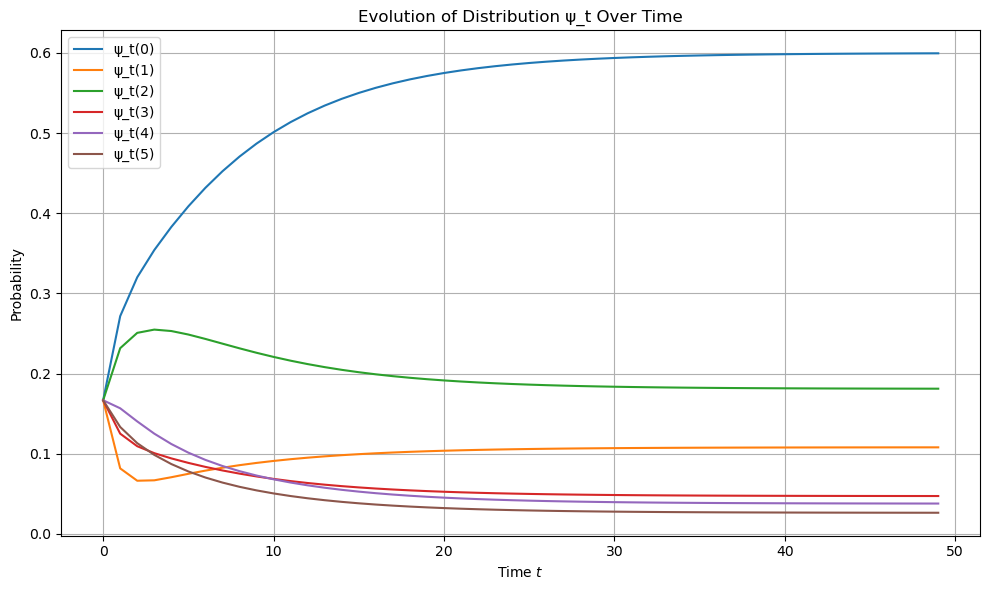

In [37]:
# soln 2
def iterate_ψ(ψ_0,P,simlength):
    n = len(P)
    ψ_t = np.empty((simlength,n)) # set correct shape for the distr
    ψ_t[0] = ψ_0
    
    for t in range(1,simlength):
        ψ_t[t] = ψ_t[t-1] @ P
    
    return ψ_t

def plot_chain(ψ_t):
    # Plots the evolution of each component of ψ_t over time.
    
    T, n = ψ_t.shape
    plt.figure(figsize=(10, 6))

    for i in range(n):
        plt.plot(range(T), ψ_t[:, i], label=f"ψ_t({i})")

    plt.xlabel("Time $t$")
    plt.ylabel("Probability")
    plt.title("Evolution of Distribution ψ_t Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

ψ_0 = np.full(6,1/6) # initial distr according to the question
simlength = 50
ψ_t = iterate_ψ(ψ_0,P,simlength)

plot_chain(ψ_t)

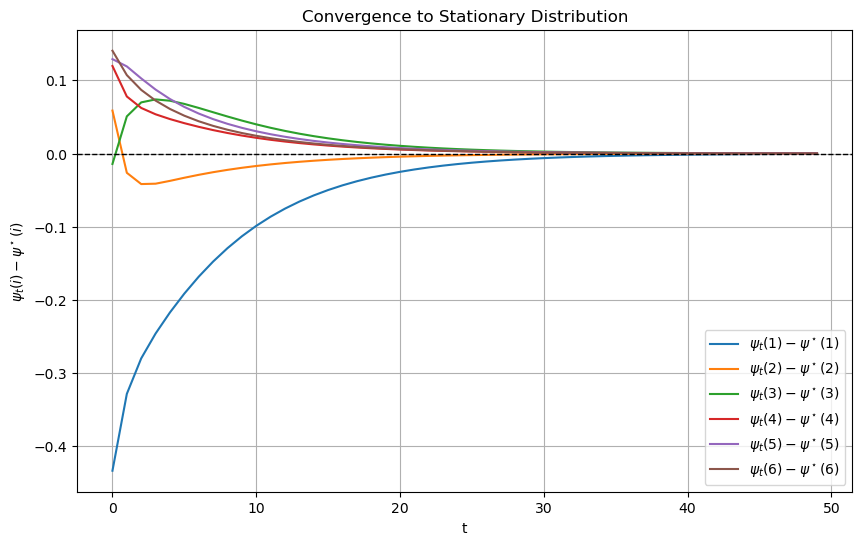

In [ ]:
def plot_convergence(ψ_0, P, simlength=100):
    n = len(P)
    ψ_t = iterate_ψ(ψ_0, P, simlength)  # shape (simlength, n)
    
    mc = qe.MarkovChain(P,nodes)
    ψ_star = mc.stationary_distributions[0]

    # subtract stationary distribution from each time step
	# diffs tending to zero proves we are reaching convergence
    diffs = ψ_t - ψ_star  # broadcasting: subtracts ψ_star from each row of ψ_t
    
    plt.figure(figsize=(10, 6))
    for i in range(n):
        plt.plot(diffs[:, i], label=fr'$\psi_t({i+1}) - \psi^\star({i+1})$')
    
    plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel('t')
    plt.ylabel(r'$\psi_t(i) - \psi^\star(i)$')
    plt.title('Convergence to Stationary Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_convergence(ψ_0,P,simlength)

(3, 3)


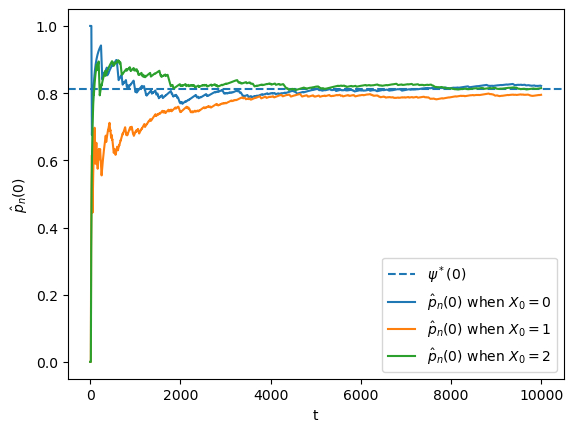

In [ ]:
P = np.array([[0.971, 0.029, 0.000],
              [0.145, 0.778, 0.077],
              [0.000, 0.508, 0.492]])
ts_length = 10_000
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
x = 0

fig, ax = plt.subplots()
ax.axhline(ψ_star[x], linestyle = 'dashed', label = fr"$\psi^*({x})$")
print(np.shape(P))
# finding fraction of time spent in state 0, with diff initial states
for x0 in range(len(P)):
    X = mc.simulate(ts_length, init=x0) # x0 ranges from 0,1 and 2 so we get all diff init states
    p_hat = (X==x).cumsum() / np.arange(1,ts_length+1) # ergodicity LHS
    ax.plot(p_hat, label = fr"$\hat p_n({x})$ when $X_0 = {x0}$")

ax.set_xlabel('t')
ax.set_ylabel(fr'$\hat p_n({x})$')
ax.legend()
plt.show()

# converged for x = 0, 1 and 2

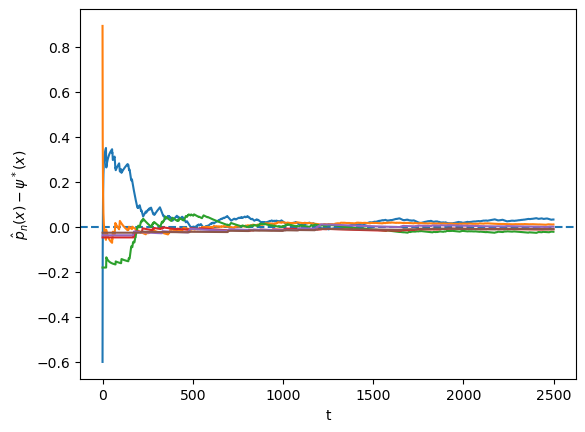

In [55]:
# visualizing the difference between ergodicity LHS and RHS to show convergence
P = [[0.86, 0.11, 0.03, 0.00, 0.00, 0.00],
     [0.52, 0.33, 0.13, 0.02, 0.00, 0.00],
     [0.12, 0.03, 0.70, 0.11, 0.03, 0.01],
     [0.13, 0.02, 0.35, 0.36, 0.10, 0.04],
     [0.00, 0.00, 0.09, 0.11, 0.55, 0.25],
     [0.00, 0.00, 0.09, 0.15, 0.26, 0.50]]

ts_length = 2500
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
X = mc.simulate(ts_length)

fig, ax = plt.subplots()
ax.axhline(0, linestyle = 'dashed')

for x0 in range(len(P)):
    p_hat = (X == x0).cumsum() / np.arange(1,ts_length+1)
    ax.plot(p_hat - ψ_star[x0])
    ax.set_xlabel("t")
    ax.set_ylabel(fr"$\hat p_n(x)-\psi^* (x)$")

plt.show()

# Exercise 35.1
Benhabib et al., 2019, estimated the transition for social mobility as the following:
~~~python
P = [
    [0.222, 0.222, 0.215, 0.187, 0.081, 0.038, 0.029, 0.006],
    [0.221, 0.22,  0.215, 0.188, 0.082, 0.039, 0.029, 0.006],
    [0.207, 0.209, 0.21,  0.194, 0.09,  0.046, 0.036, 0.008],
    [0.198, 0.201, 0.207, 0.198, 0.095, 0.052, 0.04,  0.009],
    [0.175, 0.178, 0.197, 0.207, 0.11,  0.067, 0.054, 0.012],
    [0.182, 0.184, 0.2,   0.205, 0.106, 0.062, 0.05,  0.011],
    [0.123, 0.125, 0.166, 0.216, 0.141, 0.114, 0.094, 0.021],
    [0.084, 0.084, 0.142, 0.228, 0.17,  0.143, 0.121, 0.028]
    ]
~~~

where each state 1 to 8 represents a percentile of wealth shares
$0-20\%, 20-40\%, 40-60\%, 60-80\%, 80-90\%,90-95\%, 95-99\%, 99-100\%$
1. Show this process is asymptotically stationary and calculate an approximation to the stationary distribution
2. Use simulations to illustrate ergodicity

In [60]:
# soln 1
"P is everywhere positive, so it must be asymptotically stationary."
P = [
    [0.222, 0.222, 0.215, 0.187, 0.081, 0.038, 0.029, 0.006],
    [0.221, 0.22,  0.215, 0.188, 0.082, 0.039, 0.029, 0.006],
    [0.207, 0.209, 0.21,  0.194, 0.09,  0.046, 0.036, 0.008],
    [0.198, 0.201, 0.207, 0.198, 0.095, 0.052, 0.04,  0.009],
    [0.175, 0.178, 0.197, 0.207, 0.11,  0.067, 0.054, 0.012],
    [0.182, 0.184, 0.2,   0.205, 0.106, 0.062, 0.05,  0.011],
    [0.123, 0.125, 0.166, 0.216, 0.141, 0.114, 0.094, 0.021],
    [0.084, 0.084, 0.142, 0.228, 0.17,  0.143, 0.121, 0.028]
    ]

P = np.array(P)
codes_B = ('1','2','3','4','5','6','7','8')

power = np.linalg.matrix_power(P,20)
print(power[0])
print(f"All the rows of P^20 converge to the above array, therefore it must be an approximation to the stationary distribution")

[0.20254451 0.20379879 0.20742102 0.19505842 0.09287832 0.0503871
 0.03932382 0.00858802]
All the rows of P^20 converge to the above array, therefore it must be an approximation to the stationary distribution


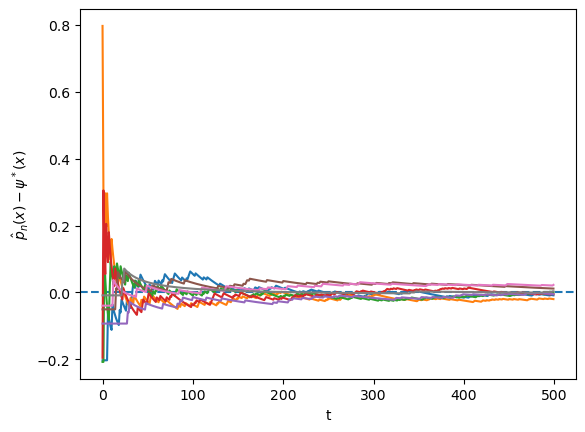

In [ ]:
# soln 2:
mc = qe.MarkovChain(P)
ψ_star = mc.stationary_distributions[0]
ts_length = 500
X = mc.simulate(ts_length)

fig, ax = plt.subplots()
ax.axhline(0, linestyle = "dashed")

for cur_state in range(len(P)):
    p_hat = (X == cur_state).cumsum()/np.arange(1,ts_length+1)
    ax.plot(p_hat - ψ_star[cur_state], label = fr"$x = {cur_state+1}")

ax.set_xlabel("t")
ax.set_ylabel(fr"$\hat p_n(x) - \psi^* (x)$")
plt.show()

# all states do converge

# Exercise 35.2
According to the previous discussion on employment, if a worker's employment dynamics obey the stochastic matrix $$P := \begin{bmatrix}
 1-\alpha & \alpha \\
\beta & 1-\beta
\end{bmatrix}$$
with $\alpha \in (0,1)$ and $\beta \in (0,1)$, then the long run fraction of time spent unemployed will be $p := \dfrac{\beta}{\alpha+\beta}$.

In other words, if $\left\{X_{t}\right\}$ represents the Markov chain for employment, then $\bar{X}_{m} \to p$ as $m \to \infty$, where $$\bar{X}_{m}:= \dfrac{1}{m}\sum_{t=1}^{m}\mathbb{1}\left\{X_{t}=0\right\}$$
This exercise asks you to illustrate convergence by computing $\bar{X}_{m}$ for large $m$ and checking that it is close to $p$. You will see that this statement is true regardless of the choice of initial condition or the values of $\alpha,\beta$, provided both lie in $(0,1)$.

For alpha = 0.8, beta = 0.64, we have the graph:


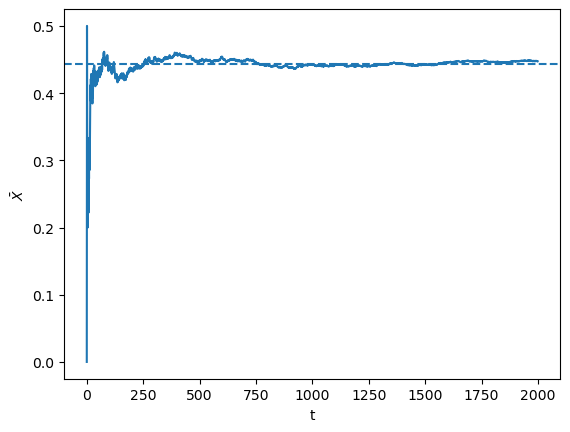

In [ ]:
# randomly generate alpha and beta in (0,1) to see if it holds regardless of alpha and beta values
α = round(np.random.uniform(low=np.nextafter(0, 1), high=1),2)
β = round(np.random.uniform(low=np.nextafter(0, 1), high=1),2)

P = [[1-α, α],
     [β, 1-β]]
P = np.asarray(P)

# expected proportion of time spent unemployed
p = round(β/(α+β),3)

mc = qe.MarkovChain(P)
ts_length = 2000
X = mc.simulate(ts_length)
X_bar = (X==0).cumsum()/np.arange(1,ts_length+1)

fig,ax = plt.subplots()
ax.axhline(p, linestyle = "dashed")
ax.plot(X_bar)

ax.set_xlabel("t")
ax.set_ylabel(fr"$\bar X$")

print(f"For alpha = {α}, beta = {β}, we have the graph:")
plt.show()

# always converges, but can exhibit weird behavior if alpha or beta are on the edge of (0,1)

# Exercise 35.3
In the `quantecon` library, irreducibility is tested by checking whether the chain forms a *strongly connected component.*

Another way to test irreducibility is via the following statement:

The $n \times n$ matrix $A$ is irreducible iff $\sum \limits_{k=0}^{n-1}A^{k}$ is a strictly positive matrix.

Based on this claim, write a function to test irreducibility.

In [ ]:
def is_irreducible(A):
    n = len(A)
    shape = np.shape(A)
    matrixsum = np.zeros(shape)
    for k in range(n):
        A_n = np.linalg.matrix_power(A,k)
        matrixsum += A_n
    if np.min(matrixsum) > 0:
        return True
    else:
        return False

P = [
    [0.222, 0.222, 0.215, 0.187, 0.081, 0.038, 0.029, 0.006],
    [0.221, 0.22,  0.215, 0.188, 0.082, 0.039, 0.029, 0.006],
    [0.207, 0.209, 0.21,  0.194, 0.09,  0.046, 0.036, 0.008],
    [0.198, 0.201, 0.207, 0.198, 0.095, 0.052, 0.04,  0.009],
    [0.175, 0.178, 0.197, 0.207, 0.11,  0.067, 0.054, 0.012],
    [0.182, 0.184, 0.2,   0.205, 0.106, 0.062, 0.05,  0.011],
    [0.123, 0.125, 0.166, 0.216, 0.141, 0.114, 0.094, 0.021],
    [0.084, 0.084, 0.142, 0.228, 0.17,  0.143, 0.121, 0.028]
    ]

is_irreducible(P)

True